In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torch.utils.data.sampler as sampler
import torchvision.datasets as datasets

import os
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
#import argparse

#from models import *
from torch.autograd import Variable
import vgg

In [3]:
print(os.getcwd())

'''
# Set hyper parameters.
'''
IMAGES_ROOT = 'datasets/PetImages'
MY_TEST_ROOT = 'datasets/my_test'
MODEL_SAVE_PATH='output'
MODEL_SAVE_INTERVAL = 5

# hyper parameters of Deep learning
IMAGE_RESIZE=64
TRAIN_SIZE = 16000
VALID_SIZE = 4000
TEST_SIZE = 4990
EPOCH_NUM = 100
BATCH_SIZE_TRAIN=25
BATCH_SIZE_VALID=50
BATCH_SIZE_TEST = 1
LR_0=0.1
MOMENTUM=0.9
WEIGHT_DECAY=5e-4
resume = False
best_acc = 0

cuda_available = torch.cuda.is_available()

C:\Users\lingyu.yue\Documents\Xiao_Fan\20180304


## Load the dog_vs_cat data

In [4]:
indices = list(range(TRAIN_SIZE+VALID_SIZE+TEST_SIZE))
np.random.seed(123)
np.random.shuffle(indices)

train_idx, valid_idx, test_idx = indices[:TRAIN_SIZE], indices[TRAIN_SIZE:(TRAIN_SIZE+VALID_SIZE)], indices[(TRAIN_SIZE+VALID_SIZE):]

train_sampler = sampler.SubsetRandomSampler(train_idx)
valid_sampler = sampler.SubsetRandomSampler(valid_idx)
test_sampler = sampler.SubsetRandomSampler(test_idx)

data_transform = transforms.Compose([
    transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE), interpolation=Image.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0], std=[1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                            0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root=IMAGES_ROOT, transform=data_transform)

train_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE_TRAIN, sampler=train_sampler, num_workers=10)

valid_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE_VALID,  sampler=valid_sampler, num_workers=10)

test_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE_TEST,  sampler=test_sampler, num_workers=10)

my_testset = datasets.ImageFolder(root=MY_TEST_ROOT, transform=data_transform)

my_data_loader = torch.utils.data.DataLoader(
    my_testset, batch_size=BATCH_SIZE_VALID, shuffle=False, num_workers=10)

print('Loaded images(train and valid), total',len(train_sampler)+len(valid_sampler))
print('Loaded test images, total',len(test_sampler))
print('Image size: ', dataset[0][0].size())

Loaded images(train and valid), total 20000
Loaded test images, total 4990
Image size:  torch.Size([3, 64, 64])


## Build the model

In [16]:
# Model
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/vgg16')
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
else:
    print('==> Building model..')
    net = vgg.VGG('VGG16')

if cuda_available:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR_0, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(net.parameters(), lr=LR_0, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)

# Training
def train(ep,display=1):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_data_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        train_acc = correct/total

    if display!=0 and ep % display==0:
        print('Epoch : %d, Train Acc : %.3f' % (ep, 100.*train_acc))
#            print('--------------------------------------------------------------')
    return train_acc
    

def evaluate(ep, data_loader,display=1):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        test_acc = correct/total

    if display!=0 and ep % display==0:
        print('Epoch : %d, Test Acc : %.3f' % (ep, 100.*test_acc))
        print('--------------------------------------------------------------')

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if cuda_available else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/vgg16')
        best_acc = acc
        
    return test_acc

def adjust_lr(optimizer, epoch, total_epochs):
    lr = LR_0 * (0.1 ** (epoch / float(total_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

==> Building model..


In [9]:
if resume==False : 
    train_acc_list = []
    valid_acc_list = []
for epoch in range(0, EPOCH_NUM):
    train_acc_list.append(train(epoch))
    adjust_lr(optimizer,epoch,EPOCH_NUM)
    valid_acc_list.append(evaluate(epoch,valid_data_loader))

Epoch : 0, Train Acc : 51.700
Epoch : 0, Test Acc : 51.350
--------------------------------------------------------------
Saving..
Epoch : 1, Train Acc : 52.050
Epoch : 1, Test Acc : 51.875
--------------------------------------------------------------
Saving..
Epoch : 2, Train Acc : 52.375
Epoch : 2, Test Acc : 52.525
--------------------------------------------------------------
Saving..
Epoch : 3, Train Acc : 51.663
Epoch : 3, Test Acc : 52.125
--------------------------------------------------------------
Epoch : 4, Train Acc : 52.819
Epoch : 4, Test Acc : 53.600
--------------------------------------------------------------
Saving..
Epoch : 5, Train Acc : 54.825
Epoch : 5, Test Acc : 56.250
--------------------------------------------------------------
Saving..
Epoch : 6, Train Acc : 56.087
Epoch : 6, Test Acc : 50.150
--------------------------------------------------------------
Epoch : 7, Train Acc : 61.544
Epoch : 7, Test Acc : 65.600
------------------------------------------

Epoch : 65, Train Acc : 96.575
Epoch : 65, Test Acc : 92.850
--------------------------------------------------------------
Saving..
Epoch : 66, Train Acc : 96.394
Epoch : 66, Test Acc : 93.075
--------------------------------------------------------------
Saving..
Epoch : 67, Train Acc : 96.650
Epoch : 67, Test Acc : 91.675
--------------------------------------------------------------
Epoch : 68, Train Acc : 96.688
Epoch : 68, Test Acc : 91.200
--------------------------------------------------------------
Epoch : 69, Train Acc : 97.006
Epoch : 69, Test Acc : 91.450
--------------------------------------------------------------
Epoch : 70, Train Acc : 96.950
Epoch : 70, Test Acc : 92.425
--------------------------------------------------------------
Epoch : 71, Train Acc : 97.000
Epoch : 71, Test Acc : 92.625
--------------------------------------------------------------
Epoch : 72, Train Acc : 97.112
Epoch : 72, Test Acc : 93.325
-----------------------------------------------------

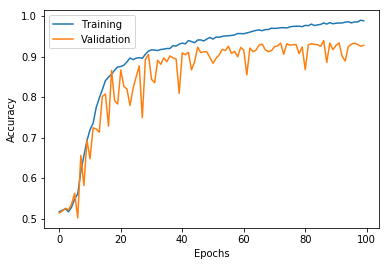

In [14]:
plt.figure()
plt.plot(range(0,EPOCH_NUM),train_acc_list,label='Training')
plt.plot(range(0,EPOCH_NUM),valid_acc_list,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# plt.savefig('problem2-accuracy1.pdf')

## VGG16 use Adam

In [19]:
LR_0=0.1
MOMENTUM=0.9
WEIGHT_DECAY=7e-4

print('==> Building model..')
net = vgg.VGG('VGG16')

if cuda_available:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR_0, weight_decay=WEIGHT_DECAY)

==> Building model..


In [20]:
if resume==False : 
    train_acc_list = []
    valid_acc_list = []
for epoch in range(0, EPOCH_NUM):
    train_acc_list.append(train(epoch))
    adjust_lr(optimizer,epoch,EPOCH_NUM)
    valid_acc_list.append(evaluate(epoch,valid_data_loader))

Epoch : 0, Train Acc : 50.550
Epoch : 0, Test Acc : 48.650
--------------------------------------------------------------
Epoch : 1, Train Acc : 50.344
Epoch : 1, Test Acc : 48.650
--------------------------------------------------------------
Epoch : 2, Train Acc : 49.394
Epoch : 2, Test Acc : 51.350
--------------------------------------------------------------
Epoch : 3, Train Acc : 50.600
Epoch : 3, Test Acc : 48.650
--------------------------------------------------------------
Epoch : 4, Train Acc : 50.844
Epoch : 4, Test Acc : 48.650
--------------------------------------------------------------
Epoch : 5, Train Acc : 50.625
Epoch : 5, Test Acc : 51.350
--------------------------------------------------------------
Epoch : 6, Train Acc : 50.525
Epoch : 6, Test Acc : 48.650
--------------------------------------------------------------
Epoch : 7, Train Acc : 50.519
Epoch : 7, Test Acc : 48.650
--------------------------------------------------------------
Epoch : 8, Train Acc : 4

KeyboardInterrupt: 

In [21]:
LR_0=0.1
MOMENTUM=0.9
WEIGHT_DECAY=7e-4

print('==> Building model..')
net = vgg.VGG('VGG16')

if cuda_available:
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR_0, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)

==> Building model..


In [22]:
if resume==False : 
    train_acc_list = []
    valid_acc_list = []
for epoch in range(0, EPOCH_NUM):
    train_acc_list.append(train(epoch))
    adjust_lr(optimizer,epoch,EPOCH_NUM)
    valid_acc_list.append(evaluate(epoch,valid_data_loader))

Epoch : 0, Train Acc : 50.456
Epoch : 0, Test Acc : 48.700
--------------------------------------------------------------
Epoch : 1, Train Acc : 50.844
Epoch : 1, Test Acc : 49.275
--------------------------------------------------------------
Epoch : 2, Train Acc : 50.644
Epoch : 2, Test Acc : 51.350
--------------------------------------------------------------
Epoch : 3, Train Acc : 51.462
Epoch : 3, Test Acc : 51.350
--------------------------------------------------------------
Epoch : 4, Train Acc : 51.206
Epoch : 4, Test Acc : 53.500
--------------------------------------------------------------
Epoch : 5, Train Acc : 54.181
Epoch : 5, Test Acc : 53.225
--------------------------------------------------------------
Epoch : 6, Train Acc : 55.594
Epoch : 6, Test Acc : 57.925
--------------------------------------------------------------
Epoch : 7, Train Acc : 59.169
Epoch : 7, Test Acc : 64.950
--------------------------------------------------------------
Epoch : 8, Train Acc : 6

Epoch : 66, Test Acc : 91.475
--------------------------------------------------------------
Epoch : 67, Train Acc : 95.263
Epoch : 67, Test Acc : 91.450
--------------------------------------------------------------
Epoch : 68, Train Acc : 95.312
Epoch : 68, Test Acc : 91.725
--------------------------------------------------------------
Epoch : 69, Train Acc : 95.769
Epoch : 69, Test Acc : 92.475
--------------------------------------------------------------
Epoch : 70, Train Acc : 95.537
Epoch : 70, Test Acc : 89.475
--------------------------------------------------------------
Epoch : 71, Train Acc : 95.469
Epoch : 71, Test Acc : 92.050
--------------------------------------------------------------
Epoch : 72, Train Acc : 95.862
Epoch : 72, Test Acc : 92.250
--------------------------------------------------------------
Epoch : 73, Train Acc : 95.694
Epoch : 73, Test Acc : 90.650
--------------------------------------------------------------
Epoch : 74, Train Acc : 95.775
Epoch : 

## Use pretrained models

In [5]:
# Training
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        train_acc = correct/total

#        utils.progress_bar(batch_idx, len(train_data_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    print('Epoch : %d, Train Acc : %.3f' % (epoch, 100.*train_acc))
#            print('--------------------------------------------------------------')
    return train_acc
    
# evaluate
def evaluate(valid_loader, model, criterion, epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        test_acc = correct/total

    print('Epoch : %d, Valid Acc : %.3f' % (epoch, 100.*test_acc))
    print('--------------------------------------------------------------')

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.module if cuda_available else net,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/vgg16')
        best_acc = acc
        
    return test_acc

# test
def test(test_loader, model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        test_acc = correct/total

    print('Test Acc : %.3f' % ( 100.*test_acc))


def adjust_lr(optimizer, epoch, total_epochs):
    lr = LR_0 * (0.1 ** (epoch / float(total_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#model = train_model(dloaders, net, criterion, optimizer, exp_lr_scheduler, num_epochs=2)
#print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=25) :
    train_acc_list=[]
    valid_acc_list=[]
    for epoch in range(0, num_epochs):
        train_acc_list.append(train(train_loader, model, criterion, optimizer, epoch))
        adjust_lr(optimizer,epoch,num_epochs)
        valid_acc_list.append(evaluate(valid_loader, model, criterion, epoch))
    return train_acc_list, valid_acc_list
    
class FineTuneModel(nn.Module):
    def __init__(self, original_model, arch, num_classes):
        super(FineTuneModel, self).__init__()

        if arch.startswith('alexnet') :
            self.features = original_model.features
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes),
            )
            self.modelName = 'alexnet'
        elif arch.startswith('resnet') :
            # Everything except the last linear layer
            self.features = nn.Sequential(*list(original_model.children())[:-1])
            self.classifier = nn.Sequential(
                nn.Linear(512, num_classes)
            )
            self.modelName = 'resnet'
        elif arch.startswith('vgg16'):
            self.features = original_model.features
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(25088, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes),
            )
            self.modelName = 'vgg16'
        else :
            raise("Finetuning not supported on this architecture yet")

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False


    def forward(self, x):
        f = self.features(x)
        if self.modelName == 'alexnet' :
            f = f.view(f.size(0), 256 * 6 * 6)
        elif self.modelName == 'vgg16':
            f = f.view(f.size(0), -1)
        elif self.modelName == 'resnet' :
            f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

In [28]:
print(os.getcwd())


'''
# Set hyper parameters.
'''
IMAGES_ROOT = 'datasets/PetImages'
MY_TEST_ROOT = 'datasets/my_test'
MODEL_SAVE_PATH='output'
MODEL_SAVE_INTERVAL = 5

# hyper parameters of Deep learning
IMAGE_RESIZE=224
TRAIN_SIZE = 16000
VALID_SIZE = 4000
TEST_SIZE = 4990
EPOCH_NUM = 100
BATCH_SIZE_TRAIN=25
BATCH_SIZE_VALID=50
BATCH_SIZE_TEST = 16
LR_0=0.1
MOMENTUM=0.9
WEIGHT_DECAY=5e-4
resume = True
best_acc = 0

cuda_available = torch.cuda.is_available()
#%%
'''
# Load the dog_vs_cat data
'''

indices = list(range(TRAIN_SIZE+VALID_SIZE+TEST_SIZE))
np.random.seed(123)
np.random.shuffle(indices)

train_idx, valid_idx, test_idx = indices[:TRAIN_SIZE], indices[TRAIN_SIZE:(TRAIN_SIZE+VALID_SIZE)], indices[(TRAIN_SIZE+VALID_SIZE):]

train_sampler = sampler.SubsetRandomSampler(train_idx)
valid_sampler = sampler.SubsetRandomSampler(valid_idx)
test_sampler = sampler.SubsetRandomSampler(test_idx)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
data_transform = transforms.Compose([
#                                      transforms.Lambda(shear),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     normalize,
                                 ])

dataset = datasets.ImageFolder(root=IMAGES_ROOT, transform=data_transform)

train_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE_TRAIN, sampler=train_sampler, num_workers=10)

valid_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE_VALID,  sampler=valid_sampler, num_workers=10)

test_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE_TEST,  sampler=test_sampler, num_workers=10)

my_testset = datasets.ImageFolder(root=MY_TEST_ROOT, transform=data_transform)

my_data_loader = torch.utils.data.DataLoader(
    my_testset, batch_size=BATCH_SIZE_VALID, shuffle=False, num_workers=10)

print('Loaded images(train and valid), total',len(train_sampler)+len(valid_sampler))
print('Loaded test images, total',len(test_sampler))
print('Image size: ', dataset[0][0].size())

C:\Users\lingyu.yue\Documents\Xiao_Fan\20180304
Loaded images(train and valid), total 20000
Loaded test images, total 4990
Image size:  torch.Size([3, 224, 224])


### Resnet 152

In [15]:
net = torchvision.models.resnet152(pretrained=True)

# freeze all model parameters
for param in net.parameters():
    param.requires_grad = False

net.fc = nn.Linear(2048, 2)

if torch.cuda.is_available():
    net = net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

In [16]:
train_acc_list=[]
valid_acc_list=[]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.module.fc.parameters(), lr=0.001, momentum=0.9)
train_acc_list, valid_acc_list = train_model(net,train_data_loader,valid_data_loader,criterion,optimizer,20)


Epoch : 0, Train Acc : 93.875
Epoch : 0, Valid Acc : 96.525
--------------------------------------------------------------
Epoch : 1, Train Acc : 92.787
Epoch : 1, Valid Acc : 95.650
--------------------------------------------------------------
Epoch : 2, Train Acc : 93.706
Epoch : 2, Valid Acc : 96.325
--------------------------------------------------------------
Epoch : 3, Train Acc : 94.956
Epoch : 3, Valid Acc : 93.925
--------------------------------------------------------------
Epoch : 4, Train Acc : 94.337
Epoch : 4, Valid Acc : 96.075
--------------------------------------------------------------
Epoch : 5, Train Acc : 94.594
Epoch : 5, Valid Acc : 96.575
--------------------------------------------------------------
Epoch : 6, Train Acc : 94.469
Epoch : 6, Valid Acc : 95.825
--------------------------------------------------------------
Epoch : 7, Train Acc : 95.213
Epoch : 7, Valid Acc : 96.825
--------------------------------------------------------------
Saving..
Epoch :

([0.93875,
  0.927875,
  0.9370625,
  0.9495625,
  0.943375,
  0.9459375,
  0.9446875,
  0.952125,
  0.95125,
  0.9526875,
  0.952,
  0.9470625,
  0.9464375,
  0.956,
  0.9546875,
  0.95175,
  0.959125,
  0.9536875,
  0.9576875,
  0.9545],
 [0.96525,
  0.9565,
  0.96325,
  0.93925,
  0.96075,
  0.96575,
  0.95825,
  0.96825,
  0.96025,
  0.9345,
  0.96625,
  0.96425,
  0.966,
  0.9695,
  0.97325,
  0.96875,
  0.96775,
  0.96525,
  0.9655,
  0.96975])

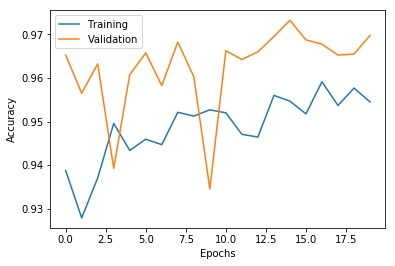

In [26]:
plt.plot(range(0,20),train_acc_list,label='Training')
plt.plot(range(0,20),valid_acc_list,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_resnet152.pdf')
plt.show()

In [29]:
# Load checkpoint.
print('==> Resuming from checkpoint..')
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpoint/vgg16')
net = checkpoint['net']
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']
print ('Best validation acc : %.3f' % (best_acc))
test(test_data_loader, net)

==> Resuming from checkpoint..
Best validation acc : 97.325
Test Acc : 96.273


# Visualization 
## dog vs cat image

torch.Size([25, 3, 224, 224]) torch.Size([25])


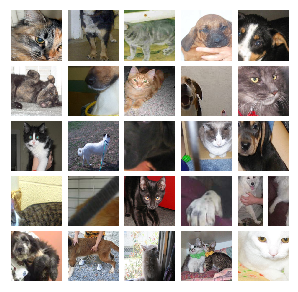

In [62]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        result = tensor
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
     
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

def plot_images(tensor, num_cols=5):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        img = transforms.ToPILImage()(unorm(tensor[i]))
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.savefig('dog_cat_images.pdf')
    plt.show()
    
img, label = next(iter(train_data_loader))
print(img.size(), label.size())
plot_images(img)

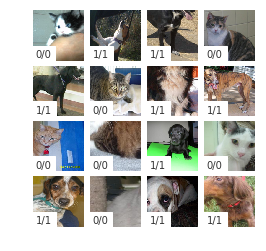

In [80]:
from mpl_toolkits.axes_grid1 import ImageGrid
# from torchvision.transforms import Compose, ToPILImage, ToTensor
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    print (inp)
#     transform1 = transforms.Compose([
#     ToPILImage(),
#     ToTensor()])
#     inp = transform1(inp)
    axis.imshow(torchinp)
    
def visualize_model(dataloders, model, num_cols = 4, num_images=16):
    cnt = 0
    num_kernels = num_images
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i, (inputs, labels) in enumerate(dataloders):
        if cuda_available:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        x = torch.FloatTensor( inputs.cpu().data.numpy() )
        for j in range(inputs.size()[0]):
            ax1 = fig.add_subplot(num_rows,num_cols,j+1)
            img = transforms.ToPILImage()(unorm(x[j]))
#             imshow(ax1,inputs[j].cpu().data)
            ax1.imshow(img)
            ax1.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            ax1.axis('off')
            cnt += 1
            if cnt == num_images:
                plt.subplots_adjust(wspace=0.1, hspace=0.1)
                plt.savefig('dog_cat_prediction.pdf')
                plt.show()  
                return 
     
visualize_model(test_data_loader, net)

## wrongly predicted examples

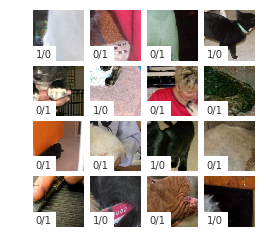

In [85]:
def visualize_wronly_predicted(dataloders, model, num_cols = 4, num_images=16):
    cnt = 0
    num_kernels = num_images
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i, (inputs, labels) in enumerate(dataloders):
        if cuda_available:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        x = torch.FloatTensor( inputs.cpu().data.numpy() )
        for j in range(inputs.size()[0]):
            if preds[j] != labels.data[j]:
                ax1 = fig.add_subplot(num_rows,num_cols,cnt+1)
                img = transforms.ToPILImage()(unorm(x[j]))
    #             imshow(ax1,inputs[j].cpu().data)
                ax1.imshow(img)
                ax1.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                        color='k', backgroundcolor='w', alpha=0.8)
                ax1.axis('off')
                cnt += 1
                if cnt == num_images:
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                    plt.savefig('dog_cat_wrong_prediction.pdf')
                    plt.show()  
                    return 
visualize_wronly_predicted(test_data_loader, net)